# Modeling - *Phragmites australis* 

All image files are stored locally.

This notebook represents initial supervised modeling efforts to classify *phragmites australis* from aerial images. To create an environment to run this code, please see the requirements.txt file. 

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import sklearn as sk
from sklearn.model_selection import train_test_split

import tensorflow as tf


mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 20

# Import Training Data

Examination of the training data. This is from local files as the images are too large to be on Github. 

In [3]:
train_directory = './new_train_data/images/'

#Grab the images
image_path = []

for file in os.listdir(train_directory):
    filename = os.fsdecode(file)
    image_path.append(train_directory + filename)

#Sort the Files
image_path = sorted(image_path)

In [4]:
#Do the paths to the files look alright? 
image_path[48]

'./new_train_data/images/000000048.tif'

In [5]:
#Running tests on example: 000000048.tif, this image should include Phragmites
with rio.open(image_path[48], 'r+') as src:
    test_image = src.read()
    test_image_meta = src.meta
    
    #Remove the null portion of the image: 6
    test_image = test_image[:5][:][:]

In [6]:
print("The shape of the training image is {0} by {1} by {2}".format(test_image.shape[0],
                                                                    test_image.shape[1],test_image.shape[2]))

The shape of the training image is 5 by 32 by 32


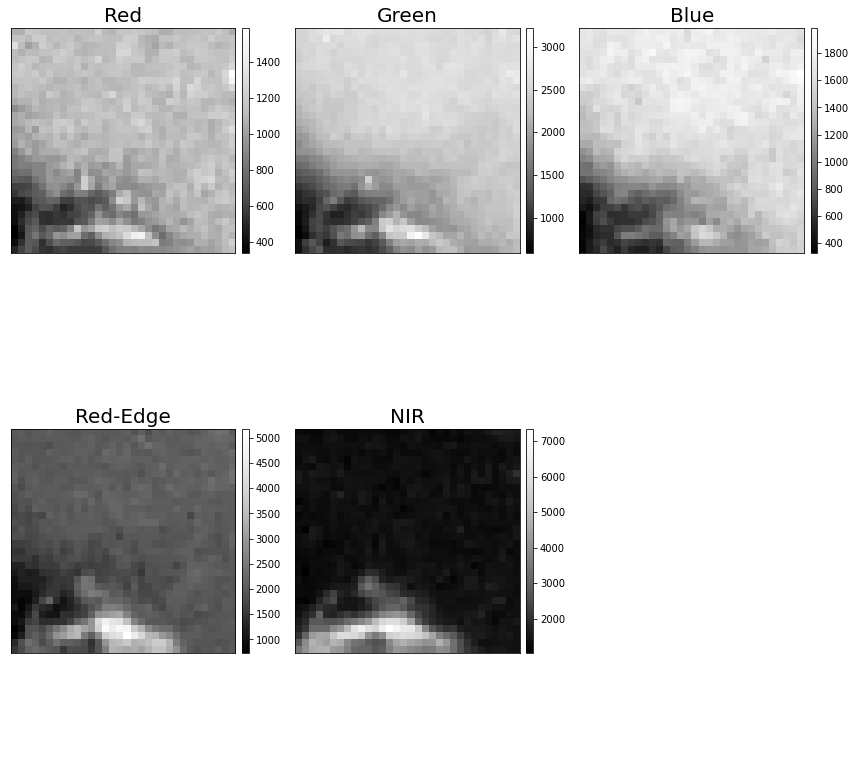

In [7]:
#Let's plot this example:
titles = ["Red", "Green", "Blue", "Red-Edge", "NIR"]
ep.plot_bands(test_image,
              scale=False,
             title=titles)
plt.show()

**Segmentation Classes:**

Within each image there are several different classes including water, soil, algae, bulrush, cattail and the invasive species of interest *Phragmites australis*. Initially, we will only try to predict this class, but in the future may move to segmentation of all labeled classes. 

In [8]:
#Let's see if we can visualize what a label looks like: 
label_directory = './new_train_data/labels/Phragmites/'
phrag_label_path = []

for file in os.listdir(label_directory):
    filename = os.fsdecode(file)
    phrag_label_path.append(label_directory + filename)

phrag_label_path = sorted(phrag_label_path)

In [9]:
#Check it matches:
print('Percentage of data with phragmites label: {0}'.format(len(phrag_label_path)/len(image_path)))

Percentage of data with phragmites label: 0.6594094840441396


In [10]:
phrag_label_path[0]

'./new_train_data/labels/Phragmites/000000048.tif'

In [11]:
#Running tests on example: 000000007
with rio.open(phrag_label_path[0], 'r+') as src:
    test_label = src.read()
    test_label_meta = src.meta

In [12]:
print("The shape of the training mask is {0} by {1} by {2}".format(test_label.shape[0],
                                                                    test_label.shape[1],test_label.shape[2]))

The shape of the training mask is 1 by 32 by 32


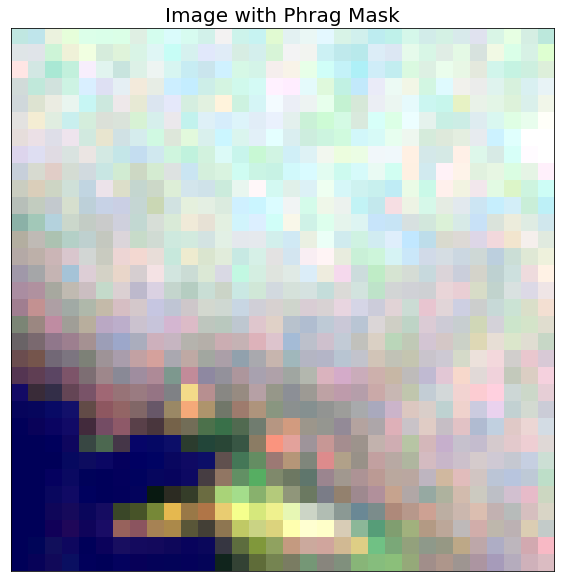

In [13]:
import numpy as np
masked = np.ma.masked_where(test_label[0] == 0, test_label[0])
f, ax = plt.subplots(1, 1)

#Plot the image
ep.plot_rgb(test_image,ax =ax,stretch = True,rgb=[0,1,2],)

#Plot the Mask
ax.imshow(masked, 'jet', interpolation='none', alpha=0.7)

#Plot settings
ax.set_title("Image with Phrag Mask")
plt.show()

**Conclusion**

Herein, we've collected the paths to both the 5x32x32 images and the corresponding 1x32x32 images. We've checked to ensure the labels correspond to images. We have selected only one class for initial training, with option to predict all classes in the future. Of note, only ~70% of images have phragmites within them. This may lead to some overfitting. We may consider using image rotations to create "new images' with no phragmites to balance the training data.  

# Data Preperation:

This step represents the collection and processing of all images. For best ease with processing in Keras, we reformat the images to be of dimension (N x X x Y x channels)

In [14]:
#Grab and process the images: 
images = []
image_name = []

for image in image_path:
    image_name.append(image.split('images/')[1])
    with rio.open(image, 'r+') as src:
        images.append(np.transpose(src.read(), (1, 2, 0)))
        
images = np.array(images)

#Take only five channels
images = images[:,:,:,:5]

In [15]:
#Data Follows format: Example number, image x pixesl, image y pixels and chanels
images.shape

(3353, 32, 32, 5)

Some masks have several layers and mixed values (0-5). This appears to simply be a result of data export from arcGIS. To correct these labels, we first flatten the matrix so it is of dimension 1x32x32 then allocate all values above 1 to become 1. This creates binary masks. 

In [16]:
phrag_masks = []
phrag_name = []

for mask in phrag_label_path:
    phrag_name.append(mask.split('Phragmites/')[1])
    
    #append the mask:
    with rio.open(mask, 'r+') as src:
        #Flatten and make anything above 1 =1 
        temp  = np.sum(src.read(),axis = 0).reshape(32,32,1)
        temp[temp>1] = 1
        phrag_masks.append(temp)

        
        
phrag_masks = np.array(phrag_masks)

#Let's Look at the shape
phrag_masks.shape

(2211, 32, 32, 1)

In [17]:
images.shape[0] - phrag_masks.shape[0]

1142

In [18]:
phrag_mask_fill = []
phrag_count = 0 

#We to back fill masks for all the images which don't have labels
for image in image_name:
    #Create null
    if image not in phrag_name:
        phrag_mask_fill.append(np.zeros([32,32,1]))
        
    #Replace otherwise
    else: 
        phrag_mask_fill.append(phrag_masks[phrag_count])
        phrag_count +=1
        
phrag_mask_fill = np.array(phrag_mask_fill)

In [19]:
phrag_mask_fill.shape

(3353, 32, 32, 1)

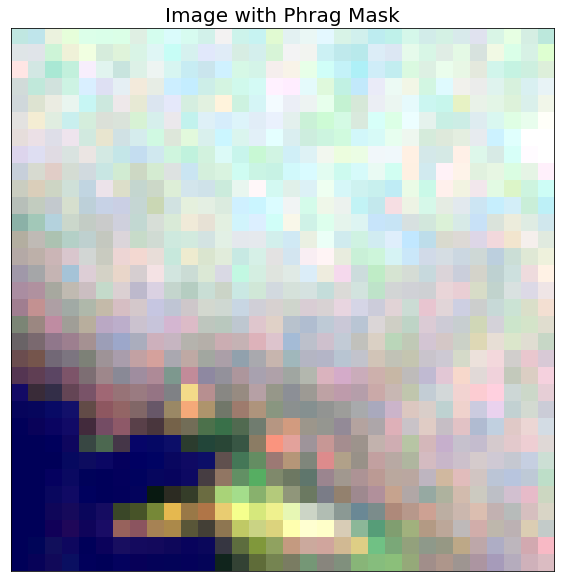

In [20]:
#Double Check!
masked = np.ma.masked_where(phrag_mask_fill[48,:,:].reshape(32,32) == 0, phrag_mask_fill[48,:,:].reshape(32,32))
f, ax = plt.subplots(1, 1)

#Plot the image
ep.plot_rgb(np.transpose(images[48], (2,0,1)),ax =ax,stretch = True,rgb=[0,1,2],)

#Plot the Mask
ax.imshow(masked, 'jet', interpolation='none', alpha=0.7)

#Plot settings
ax.set_title("Image with Phrag Mask")
plt.show()

# Descriptive Statatistics 

**How many images have the plant of interest within?**

Text(0.5, 1.0, 'Label Balance in Dataset')

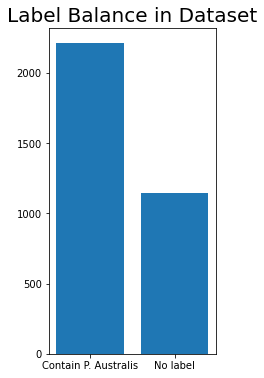

In [21]:
fig,ax = plt.subplots(1,figsize=(3, 6))
ax.bar(['Contain P. Australis','No label'],[phrag_masks.shape[0],images.shape[0]-phrag_masks.shape[0]])
ax.set_title('Label Balance in Dataset')

**Conclusion**

We have not explored the details of the data well. We will attempt to perform so more basic analysis on the images to see if there are any existing artifacts which need attention. If we introduce more classes for prediction, we will add more bar graphs as well.

# Feature Engineering: 

Currently we have no feature engineering being performed as we are simply using the raw chanel data. Some ideas we would like to implement:

1. Pixel standardization
2. Usage of other channels created by combining several of the raw features (NDVI or False composite)
3. Image alteration to increase the size training data (rotations, zoom in)


# Train/Test Split

We will perform an 80/20 split of data for training and testing respectively. This leaves 2,682 images for training and 671 images for testing. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(images, 
                                                                       phrag_mask_fill, 
                                                                       test_size=0.20, 
                                                                       random_state=42)

In [23]:
X_train.shape

(2682, 32, 32, 5)

# UNet in Keras

UNet is architecture developed by Ronneberger *et al* (https://arxiv.org/abs/1505.04597) created to segment biomedical images. It consists of an encoder and decoder. This network works by taking the image and reducing it into a high dimensional space via system of convolutions and pooling. To create the desired output, a binary segmentation mask, UNet utilizes deconvolutions to expand the high dimensional vector back to the original image dimensions allowing for creation of a high quality image mask. 

See: 
1. https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 
2. https://www.tensorflow.org/tutorials/images/segmentation

Changes:

1. Based on gridsearch the best optimizer is ADAM
2. Based on hyperparameter search: the dropout level should be set to 0.01
3. Kernel Intializer was changed from he to xavier normal
4. Added l2 regularization to try and decrease the over fitting (0.01 > 0.1)

Highest accuracy on test set: 0.86

In [197]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'glorot_normal', padding = 'same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_tensor)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'glorot_normal', padding = 'same',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_tensor)
    if batchnorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [198]:
def unet_v1(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Build the network
    
    #Encoder
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    #Decoder
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    #We can use a sigmoid activation function for the final layer as we are doing only one class
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [199]:
# Parameters based upon the size of the input. 
im_width = 32
im_height = 32
border = 2

In [200]:
input_img = tf.keras.layers.Input((im_height, im_width,5), name='img')
model = unet_v1(input_img, n_filters=16, dropout=0.01, batchnorm=True)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [201]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_628 (Conv2D)             (None, 32, 32, 16)   736         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_595 (BatchN (None, 32, 32, 16)   64          conv2d_628[0][0]                 
__________________________________________________________________________________________________
activation_595 (Activation)     (None, 32, 32, 16)   0           batch_normalization_595[0][0]    
___________________________________________________________________________________________

In [202]:
#This allocates that the network should perform early stopping if the rate of improvement drops below 0.0001
#It saves the best performing network weights to v1_unet.h5
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('v1_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [203]:
#Run the model!
results = model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Train on 2682 samples, validate on 671 samples
Epoch 1/50
2624/2682 [============================>.] - ETA: 0s - loss: 3.1820 - accuracy: 0.7649
Epoch 00001: val_loss improved from inf to 1.42550, saving model to v1_unet.h5
2682/2682 [==============================] - 3s 1ms/sample - loss: 3.1420 - accuracy: 0.7652 - val_loss: 1.4255 - val_accuracy: 0.6236
Epoch 2/50
2624/2682 [============================>.] - ETA: 0s - loss: 0.8887 - accuracy: 0.8245
Epoch 00002: val_loss improved from 1.42550 to 0.80876, saving model to v1_unet.h5
2682/2682 [==============================] - 1s 203us/sample - loss: 0.8832 - accuracy: 0.8254 - val_loss: 0.8088 - val_accuracy: 0.7455
Epoch 3/50
2304/2682 [========================>.....] - ETA: 0s - loss: 0.6332 - accuracy: 0.8272
Epoch 00003: val_loss improved from 0.80876 to 0.66433, saving model to v1_unet.h5
2682/2682 [==============================] - 1s 202us/sample - loss: 0.6242 - accuracy: 0.8284 - val_loss: 0.6643 - val_accuracy: 0.7595
Epoch

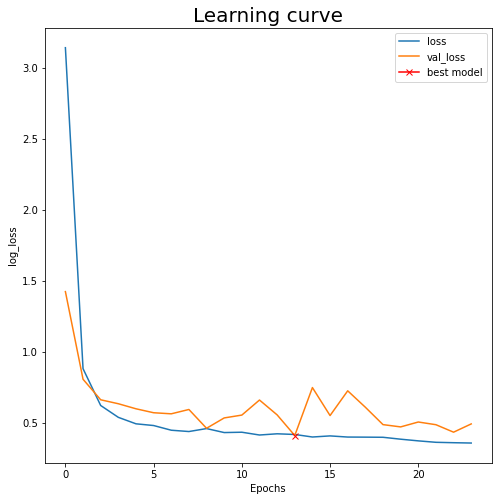

In [204]:
#Plot the loss function: See how it changes overtime
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# Model Evaluation

In [205]:
# load the best model
model.load_weights('v1_unet.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
loss,accuracy = model.evaluate(X_test, y_test, verbose=1)

671/671 [==============================] - 0s 132us/sample - loss: 0.4129 - accuracy: 0.8422


In [206]:
print('The model showcases a cost function loss of: {0}'.format(loss))
print('The current pixel accuracy of this basic UNet is: {0}'.format(accuracy))

The model showcases a cost function loss of: 0.41287169957480735
The current pixel accuracy of this basic UNet is: 0.842160701751709


In [207]:
#Visualizing predictions: 
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Need binaries: 
preds_train_thres = (preds_train > 0.5).astype(np.uint16)
preds_test_thres = (preds_test > 0.5).astype(np.uint16)

671/671 [==============================] - 0s 105us/sample


In [158]:
preds_train_thres.shape

(2682, 32, 32, 1)

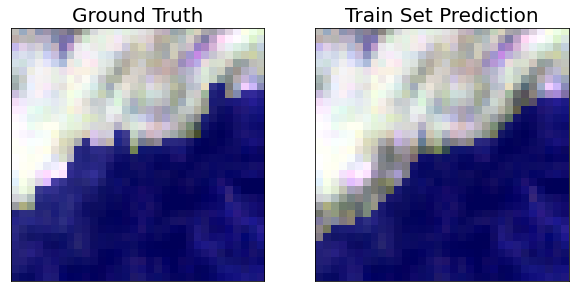

In [159]:
#Check it out
masked_pred = np.ma.masked_where(preds_train_thres[0,:,:].reshape(32,32) == 0, 
                            preds_train_thres[0,:,:].reshape(32,32))

masked_true = np.ma.masked_where(y_train[0,:,:].reshape(32,32) == 0, 
                            y_train[0,:,:].reshape(32,32))

f, (ax1,ax2) = plt.subplots(1, 2)

#Plot the image
ep.plot_rgb(np.transpose(X_train[0], (2,0,1)),ax =ax1,stretch = True,rgb=[0,1,2],)
#Plot the Mask
ax1.imshow(masked_true, 'jet', interpolation='none', alpha=0.7)
ax1.set_title('Ground Truth')

ep.plot_rgb(np.transpose(X_train[0], (2,0,1)),ax =ax2,stretch = True,rgb=[0,1,2],)
ax2.imshow(masked_pred, 'jet', interpolation='none', alpha=0.7)
ax2.set_title("Train Set Prediction")

plt.show()

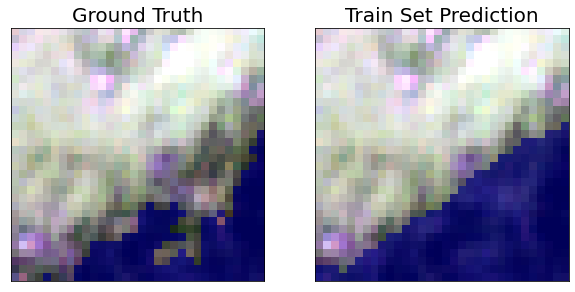

In [160]:
#Check it out
masked_pred = np.ma.masked_where(preds_test_thres[1,:,:].reshape(32,32) == 0, 
                            preds_test_thres[1,:,:].reshape(32,32))

masked_true = np.ma.masked_where(y_test[1,:,:].reshape(32,32) == 0, 
                            y_test[1,:,:].reshape(32,32))

f, (ax1,ax2) = plt.subplots(1, 2)

#Plot the image
ep.plot_rgb(np.transpose(X_test[1], (2,0,1)),ax =ax1,stretch = True,rgb=[0,1,2],)
#Plot the Mask
ax1.imshow(masked_true, 'jet', interpolation='none', alpha=0.7)
ax1.set_title('Ground Truth')

ep.plot_rgb(np.transpose(X_test[1], (2,0,1)),ax =ax2,stretch = True,rgb=[0,1,2],)
ax2.imshow(masked_pred, 'jet', interpolation='none', alpha=0.7)
ax2.set_title("Train Set Prediction")

plt.show()

## Hyperparameter Tuning:

In [142]:
from tensorboard.plugins.hparams import api as hp
import datetime, os
%reload_ext tensorboard
!rm -rf ./logs/ 

In [143]:
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.001,0.01, 0.1]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
      hp.hparams_config(
        hparams=[HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')])


In [144]:
def train_test_model(hparams):
    #Set the model
    model = unet_v1(input_img, n_filters=16, dropout=hparams[HP_DROPOUT], batchnorm=True)
    model.compile(optimizer=hparams[HP_OPTIMIZER], loss="binary_crossentropy", metrics=["accuracy"])
    
    #Create a log directory
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  
    
    #initialize the callback:
    callbacks = [
        #tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        #tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
        #tf.keras.callbacks.ModelCheckpoint('v1_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams)]
    
    #fit the model
    model.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=callbacks) 
    _, accuracy = model.evaluate(X_test, y_test)
    
    return accuracy

In [145]:
session_num = 0
for dropout_rate in (HP_DROPOUT.domain.values):
    for optimizer in HP_OPTIMIZER.domain.values:

        hparams = {
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              }

        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1


--- Starting trial: run-0
{'dropout': 0.001, 'optimizer': 'adam'}
Train on 2682 samples
Epoch 1/50
2682/2682 [==============================] - 2s 608us/sample - loss: 0.5033 - accuracy: 0.7551
Epoch 2/50
2682/2682 [==============================] - 0s 170us/sample - loss: 0.4029 - accuracy: 0.8227
Epoch 3/50
2682/2682 [==============================] - 0s 165us/sample - loss: 0.3783 - accuracy: 0.8287
Epoch 4/50
2682/2682 [==============================] - 0s 168us/sample - loss: 0.3525 - accuracy: 0.8446
Epoch 5/50
2682/2682 [==============================] - 0s 168us/sample - loss: 0.3435 - accuracy: 0.8472
Epoch 6/50
2682/2682 [==============================] - 0s 163us/sample - loss: 0.3380 - accuracy: 0.8506
Epoch 7/50
2682/2682 [==============================] - 0s 166us/sample - loss: 0.3152 - accuracy: 0.8604
Epoch 8/50
2682/2682 [==============================] - 0s 172us/sample - loss: 0.3114 - accuracy: 0.8621
Epoch 9/50
2682/2682 [==============================] - 0s 170us

2682/2682 [==============================] - 0s 167us/sample - loss: 0.4170 - accuracy: 0.7995
Epoch 26/50
2682/2682 [==============================] - 0s 167us/sample - loss: 0.4154 - accuracy: 0.7998
Epoch 27/50
2682/2682 [==============================] - 0s 165us/sample - loss: 0.4144 - accuracy: 0.8011
Epoch 28/50
2682/2682 [==============================] - 0s 164us/sample - loss: 0.4072 - accuracy: 0.8051
Epoch 29/50
2682/2682 [==============================] - 0s 160us/sample - loss: 0.4084 - accuracy: 0.8051
Epoch 30/50
2682/2682 [==============================] - 0s 166us/sample - loss: 0.4017 - accuracy: 0.8086
Epoch 31/50
2682/2682 [==============================] - 0s 164us/sample - loss: 0.4006 - accuracy: 0.8090
Epoch 32/50
2682/2682 [==============================] - 0s 160us/sample - loss: 0.3982 - accuracy: 0.8112
Epoch 33/50
2682/2682 [==============================] - 0s 158us/sample - loss: 0.3979 - accuracy: 0.8104
Epoch 34/50
2682/2682 [==========================

671/671 [==============================] - 0s 442us/sample - loss: 0.4300 - accuracy: 0.8526
--- Starting trial: run-3
{'dropout': 0.01, 'optimizer': 'sgd'}
Train on 2682 samples
Epoch 1/50
2682/2682 [==============================] - 1s 522us/sample - loss: 0.6779 - accuracy: 0.5865
Epoch 2/50
2682/2682 [==============================] - 0s 163us/sample - loss: 0.5701 - accuracy: 0.6789
Epoch 3/50
2682/2682 [==============================] - 0s 170us/sample - loss: 0.5394 - accuracy: 0.7066
Epoch 4/50
2682/2682 [==============================] - 0s 167us/sample - loss: 0.5222 - accuracy: 0.7203
Epoch 5/50
2682/2682 [==============================] - 0s 164us/sample - loss: 0.5102 - accuracy: 0.7291
Epoch 6/50
2682/2682 [==============================] - 0s 169us/sample - loss: 0.5014 - accuracy: 0.7344
Epoch 7/50
2682/2682 [==============================] - 0s 170us/sample - loss: 0.4929 - accuracy: 0.7414
Epoch 8/50
2682/2682 [==============================] - 0s 160us/sample - loss:

2682/2682 [==============================] - 0s 174us/sample - loss: 0.2917 - accuracy: 0.8727
Epoch 24/50
2682/2682 [==============================] - 0s 160us/sample - loss: 0.2925 - accuracy: 0.8710
Epoch 25/50
2682/2682 [==============================] - 0s 173us/sample - loss: 0.2861 - accuracy: 0.8749
Epoch 26/50
2682/2682 [==============================] - 0s 167us/sample - loss: 0.2902 - accuracy: 0.8718
Epoch 27/50
2682/2682 [==============================] - 0s 178us/sample - loss: 0.2794 - accuracy: 0.8778
Epoch 28/50
2682/2682 [==============================] - 0s 164us/sample - loss: 0.2761 - accuracy: 0.8781
Epoch 29/50
2682/2682 [==============================] - 0s 176us/sample - loss: 0.2741 - accuracy: 0.8820
Epoch 30/50
2682/2682 [==============================] - 0s 166us/sample - loss: 0.2791 - accuracy: 0.8772
Epoch 31/50
2682/2682 [==============================] - 0s 169us/sample - loss: 0.2708 - accuracy: 0.8831
Epoch 32/50
2682/2682 [==========================

2682/2682 [==============================] - 0s 159us/sample - loss: 0.3884 - accuracy: 0.8176
Epoch 49/50
2682/2682 [==============================] - 0s 156us/sample - loss: 0.3911 - accuracy: 0.8171
Epoch 50/50
671/671 [==============================] - 0s 427us/sample - loss: 0.3897 - accuracy: 0.8141


In [146]:
%tensorboard --logdir logs/hparam_tuning